In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import acquire
import summarize
import prepare

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# ACQUIRE

In [4]:
df = pd.read_csv('data.csv')

In [39]:
df.logerror.mean()

0.01659829124491966

#### Keep the Master Latitude Longitude DataFrame

In [5]:
lat_long = df[['latitude','longitude']]

In [8]:
len(lat_long)

73424

# Prepare

### Get rid of nulls. Heating will get imputed. Null rows will be dropped.

In [9]:
#The columns that have to do with the building themselves. No location data except for lat-long.
house_vars = ['fullbathcnt','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','heatingorsystemtypeid','lotsizesquarefeet','yearbuilt','structuretaxvaluedollarcnt', 'taxvaluedollarcnt','latitude','longitude','logerror']

In [10]:
house_vars

['fullbathcnt',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'heatingorsystemtypeid',
 'lotsizesquarefeet',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'latitude',
 'longitude',
 'logerror']

In [11]:
structures_df = df[house_vars]

In [12]:
structures_df.heatingorsystemtypeid.fillna(2, inplace=True)

In [13]:
structures_df.dropna(inplace=True)

In [15]:
summarize.nulls_by_col(structures_df)

,num_rows_missing,pct_rows_missing
fullbathcnt,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
calculatedfinishedsquarefeet,0,0.0
heatingorsystemtypeid,0,0.0
lotsizesquarefeet,0,0.0
yearbuilt,0,0.0
structuretaxvaluedollarcnt,0,0.0
taxvaluedollarcnt,0,0.0
latitude,0,0.0


### Split into the train and test sets

In [16]:
train, test = train_test_split(structures_df, train_size = .8, random_state = 123)

In [21]:
train.drop(['latitude','longitude'],axis=1,inplace=True)

test.drop(['latitude','longitude'],axis=1,inplace=True)

In [19]:
train.head()

,fullbathcnt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,heatingorsystemtypeid,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,logerror
61754,2.0,2.5,3.0,1773.0,2.0,3400.0,1991.0,211009.0,792686.0,0.179380
47292,2.0,2.0,3.0,1472.0,2.0,3478.0,1980.0,119984.0,267303.0,-0.249122
64754,4.0,4.0,4.0,3359.0,2.0,14043.0,1985.0,390284.0,852412.0,-0.009638
26374,3.0,3.0,3.0,2608.0,2.0,10946.0,1987.0,134116.0,194891.0,0.015984
56288,3.0,3.0,5.0,1930.0,2.0,7521.0,1960.0,99766.0,607280.0,-0.073379


### USE STANDARD SCALING

In [22]:
standard_train, standard_test, standard_object = prepare.standardize_train_test(train, test)

### Drop the upper outliers

In [23]:
no_outliers = prepare.remove_upper_outliers(standard_train.calculatedfinishedsquarefeet, train)
no_outliers = prepare.remove_upper_outliers(standard_train.lotsizesquarefeet, train)

In [27]:
no_outliers.shape

(43645, 10)

In [28]:
kmean = KMeans(n_clusters=3)

In [29]:
kmean.fit(standard_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [31]:
predictions3 = kmean.labels_

standard_train['cluster_labels3'] = predictions3

In [33]:
np.unique(predictions3, return_counts=True)

(array([0, 1, 2], dtype=int32), array([ 4520, 13820, 33860]))

In [34]:
standard_train.groupby('cluster_labels3').mean()

,fullbathcnt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,heatingorsystemtypeid,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,logerror
cluster_labels3,,,,,,,,,,
0,2.032621,2.087592,1.374876,2.243567,-0.441037,-0.078210,0.733096,1.994253,1.745499,0.098596
1,-0.946069,-0.970138,-0.646101,-0.680541,1.308782,-0.091297,-0.937422,-0.434060,-0.303003,-0.024520
2,0.114803,0.117289,0.080174,-0.021732,-0.475307,0.047703,0.284748,-0.089052,-0.109337,-0.003154


In [38]:
## THE 2nd Cluster does the best. Very low log error.

In [35]:
standard_train[['latitude','longitude']] = lat_long

In [36]:
standard_train.head()

,fullbathcnt,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,heatingorsystemtypeid,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,logerror,cluster_labels3,latitude,longitude
61754,-0.263107,0.202709,-0.111110,-0.038328,-0.503403,-0.220779,1.042818,0.082098,0.453035,0.980322,2,33517362.0,-117693103.0
47292,-0.263107,-0.314795,-0.111110,-0.355275,-0.503403,-0.220151,0.556773,-0.308258,-0.350412,-1.615293,2,33616901.0,-117632943.0
64754,1.849841,1.755222,0.900740,1.631703,-0.503403,-0.135126,0.777702,0.850910,0.544372,-0.164638,0,34159741.0,-118779874.0
26374,0.793367,0.720213,-0.111110,0.840913,-0.503403,-0.160050,0.866074,-0.247653,-0.461149,-0.009435,2,34079372.0,-117839908.0
56288,0.793367,0.720213,1.912589,0.126991,-0.503403,-0.187614,-0.326946,-0.394962,0.169501,-0.550744,2,33721710.0,-117991767.0


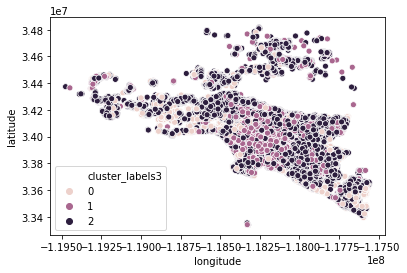

In [37]:
sns.scatterplot(data=standard_train, x='longitude', y='latitude', hue='cluster_labels3')

In [44]:
import cluster

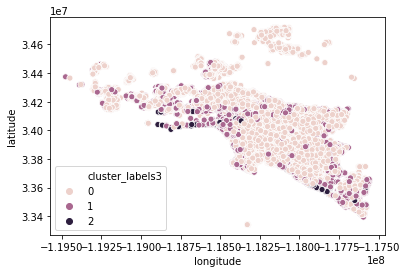

In [45]:
cluster.show_clusters_on_map()